# NBA Player Analysis: Are the type of players changing?

# Imports

In [515]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Building
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

# Resources

Data:

https://www.kaggle.com/abhinavp23/nba-stats-player-and-team

Other Projects:

https://randerson112358.medium.com/nba-data-analysis-exploration-9293f311e0e8

https://dribbleanalytics.blog/2019/04/positional-clustering/

http://suruchifialoke.com/2017-06-01-clustering-nba-players/

https://www.kaggle.com/terrycheng/nba-players-clustering-using-pca-and-kmeans

Rule Changes:

https://cdn.nba.net/nba-drupal-prod/nba-rules-changes-history.pdf

Possible Stats Additions:

https://bleacherreport.com/articles/1039116-understanding-the-nba-explaining-advanced-offensive-stats-and-metrics

# Load Data

In [339]:
data = pd.read_csv('../data/NBA_Season_Stats.csv')

In [340]:
data.shape

(27943, 31)

In [341]:
data.sort_values('Year', inplace=True)

# Clean Data

In [342]:
# Removes second index column.
data.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [343]:
# Removes rows with null values.
data.dropna(axis=0, inplace=True)

In [344]:
data.shape

(17363, 30)

In [345]:
# Strips * from names and records each player that was in the Hall of Fame as 1 and 0 otherwise.
players = []
hf = []

for player_name in data['Player']:
    if player_name.endswith('*'):
        players.append(player_name.strip('*'))
        hf.append(1)
    else:
        players.append(player_name)
        hf.append(0)

In [346]:
len(players)

17363

In [347]:
len(hf)

17363

In [348]:
# Replaces column, Player, with stripped names.
# Adds column, HF, to indicate whether or not a player was inducted into the Hall of Fame
data['Player'] = players
data['HF'] = hf

In [349]:
data.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,HF
5919,1980.0,Pete Maravich,SG,32.0,BOS,26.0,4.0,442.0,123.0,249.0,...,10.0,28.0,38.0,29.0,9.0,2.0,37.0,49.0,299.0,1
5917,1980.0,Pete Maravich,SG,32.0,TOT,43.0,4.0,964.0,244.0,543.0,...,17.0,61.0,78.0,83.0,24.0,6.0,82.0,79.0,589.0,1
5974,1980.0,Rick Robey,C,24.0,BOS,82.0,27.0,1918.0,379.0,727.0,...,209.0,321.0,530.0,92.0,53.0,15.0,151.0,244.0,942.0,0
5700,1980.0,Tiny Archibald,PG,31.0,BOS,80.0,80.0,2864.0,383.0,794.0,...,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0,1
5756,1980.0,Don Chaney,SG,33.0,BOS,60.0,0.0,523.0,67.0,189.0,...,31.0,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0,0


In [350]:
data.columns

Index(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'HF'],
      dtype='object')

In [351]:
# Sums up player's season stats if they were traded within a season.
players = data.groupby(['Year', 'Player', 'Pos'])[['G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']].sum().reset_index()

In [352]:
# Adds the column, HF.
players['HF'] = data.groupby(['Year', 'Player', 'Pos'])['HF'].max().reset_index()['HF']

In [353]:
players

,Year,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,HF
0,1980.0,Chris Ford,SG,73.0,73.0,2115.0,330.0,709.0,0.465,70.0,...,77.0,104.0,181.0,215.0,111.0,27.0,105.0,178.0,816.0,0
1,1980.0,Dave Cowens,C,66.0,55.0,2159.0,422.0,932.0,0.453,1.0,...,126.0,408.0,534.0,206.0,69.0,61.0,108.0,216.0,940.0,1
2,1980.0,Don Chaney,SG,60.0,0.0,523.0,67.0,189.0,0.354,1.0,...,31.0,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0,0
3,1980.0,Gerald Henderson,PG,76.0,2.0,1061.0,191.0,382.0,0.500,2.0,...,37.0,46.0,83.0,147.0,45.0,15.0,109.0,96.0,473.0,0
4,1980.0,Jeff Judkins,SF,65.0,0.0,674.0,139.0,276.0,0.504,11.0,...,32.0,34.0,66.0,47.0,29.0,5.0,49.0,91.0,351.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13719,2019.0,Zach Collins,C,77.0,0.0,17.6,2.5,5.2,0.473,0.5,...,1.4,2.8,4.2,0.9,0.3,0.9,1.0,2.3,6.6,0
13720,2019.0,Zach LaVine,SG,63.0,62.0,34.5,8.4,18.0,0.467,1.9,...,0.6,4.0,4.7,4.5,1.0,0.4,3.4,2.2,23.7,0
13721,2019.0,Zaza Pachulia,C,68.0,3.0,12.9,1.3,2.8,0.440,0.0,...,1.5,2.4,3.9,1.3,0.5,0.3,0.8,2.2,3.9,0
13722,2019.0,Zhaire Smith,SG,6.0,2.0,18.5,2.3,5.7,0.412,1.0,...,0.5,1.7,2.2,1.7,0.3,0.3,1.0,1.3,6.7,0


In [354]:
# Recalculates the percentage columns.
players['FG%'] = players['FG']/players['FGA']
players['FT%'] = players['FT']/players['FTA']
players['3P%'] = players['3P']/players['3PA']
players['2P%'] = players['2P']/players['2PA']
players['eFG%'] = (players['FG'] + 0.5*players['3P'])/players['FGA']

In [355]:
# Changes the year column to an integer
players['Year'] = players['Year'].astype(int)

In [356]:
# Transforms categorical column, Pos, into dummy variables.
players = pd.get_dummies(players, columns=['Pos'])

In [357]:
# Shape of new dataframe.
players.shape

(13724, 44)

In [358]:
# Drops any leftover null values.
players.dropna(axis=0, inplace=True)

In [359]:
players

,Year,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,...,Pos_PG,Pos_PG-SF,Pos_PG-SG,Pos_SF,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF
0,1980,Chris Ford,73.0,73.0,2115.0,330.0,709.0,0.465444,70.0,164.0,...,0,0,0,0,0,0,1,0,0,0
1,1980,Dave Cowens,66.0,55.0,2159.0,422.0,932.0,0.452790,1.0,12.0,...,0,0,0,0,0,0,0,0,0,0
2,1980,Don Chaney,60.0,0.0,523.0,67.0,189.0,0.354497,1.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,1980,Gerald Henderson,76.0,2.0,1061.0,191.0,382.0,0.500000,2.0,6.0,...,1,0,0,0,0,0,0,0,0,0
4,1980,Jeff Judkins,65.0,0.0,674.0,139.0,276.0,0.503623,11.0,27.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13719,2019,Zach Collins,77.0,0.0,17.6,2.5,5.2,0.480769,0.5,1.6,...,0,0,0,0,0,0,0,0,0,0
13720,2019,Zach LaVine,63.0,62.0,34.5,8.4,18.0,0.466667,1.9,5.1,...,0,0,0,0,0,0,1,0,0,0
13721,2019,Zaza Pachulia,68.0,3.0,12.9,1.3,2.8,0.464286,0.0,0.1,...,0,0,0,0,0,0,0,0,0,0
13722,2019,Zhaire Smith,6.0,2.0,18.5,2.3,5.7,0.403509,1.0,2.7,...,0,0,0,0,0,0,1,0,0,0


In [360]:
# Splits data on 1999 where the five second rule was implemented.
# Five second rule makes the game go faster forcing players to make decisions faster.
pre_rule = players[players['Year']<=1999]
post_rule = players[players['Year']>1999]

In [361]:
pre_rule.shape

(5578, 44)

In [362]:
post_rule.shape

(8108, 44)

# EDA

In [363]:
players.columns

Index(['Year', 'Player', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'HF', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF'],
      dtype='object')

In [364]:
pos_pre = pre_rule[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]
pos_post = post_rule[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]

In [365]:
main_pre = pos_pre[['Pos_C', 'Pos_PF', 'Pos_SF', 'Pos_SG', 'Pos_PG']]
main_post = pos_post[['Pos_C', 'Pos_PF', 'Pos_SF', 'Pos_SG', 'Pos_PG']]

other_pre = pos_pre[['Pos_C-PF', 'Pos_C-SF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG-SF', 
                     'Pos_PG-SG', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]
other_post = pos_post[['Pos_C-PF', 'Pos_C-SF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG-SF', 
                     'Pos_PG-SG', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]

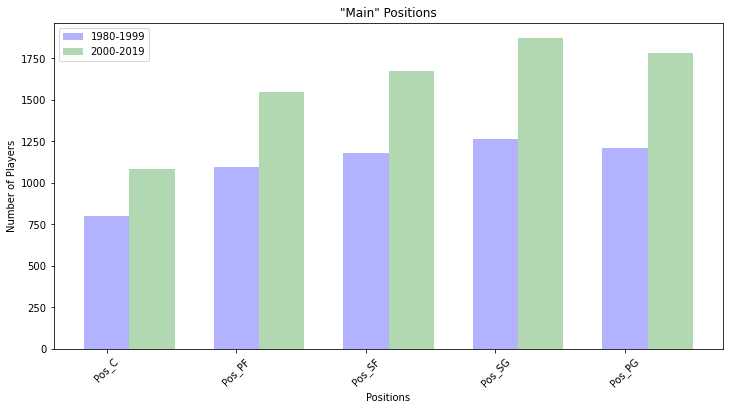

In [366]:
pos = 5
idx = np.arange(pos)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(idx, main_pre.sum(), width, color='blue', alpha=0.3, label='1980-1999')
ax.bar(idx+width, main_post.sum(), width, color='green', alpha=0.3, label='2000-2019')

ax.set_title('"Main" Positions')
ax.set_xlabel('Positions')
ax.set_ylabel('Number of Players')
ax.set_xticks(idx)
ax.set_xticklabels(main_pre.columns, rotation=45)

ax.legend();

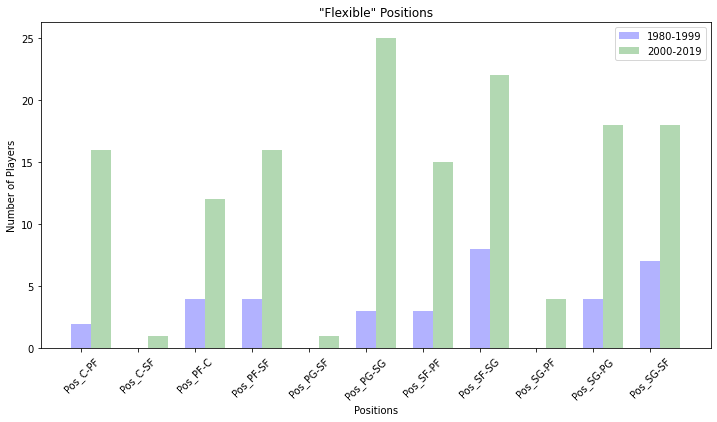

In [367]:
pos = 11
idx = np.arange(pos)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(idx, other_pre.sum(), width, color='blue', alpha=0.3, label='1980-1999')
ax.bar(idx+width, other_post.sum(), width, color='green', alpha=0.3, label='2000-2019')

ax.set_title('"Flexible" Positions')
ax.set_xlabel('Positions')
ax.set_ylabel('Number of Players')
ax.set_xticks(idx)
ax.set_xticklabels(other_pre.columns, rotation=45)

ax.legend();

__There are more players overall, which is to be expected since the organization is growing. However, there appears to be more of these 'flexible' players that can play more than one position.__

__C__: Center, 5 (ie. Shaquille O'Neal)

__PF__: Power Foward, 4 (ie. Chris Bosh)

__SF__: Small Foward, 3 (ie. Kawhi Leonard)

__SG__: Shooting Guard, 2 (ie. Klay Thompson)

__PG__: Point Guard, 1 (ie. Stephen Curry)

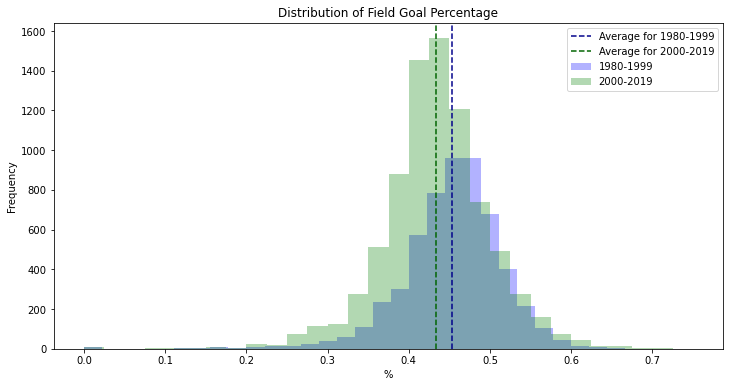

In [368]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(pre_rule['FG%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['FG%'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['FG%'].mean(), color='darkblue', linestyle='dashed', label='Average for 1980-1999')
ax.axvline(post_rule['FG%'].mean(), color='darkgreen', linestyle='dashed', label='Average for 2000-2019')

ax.set_title('Distribution of Field Goal Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

__It appears that the field goal percentage decreased.__

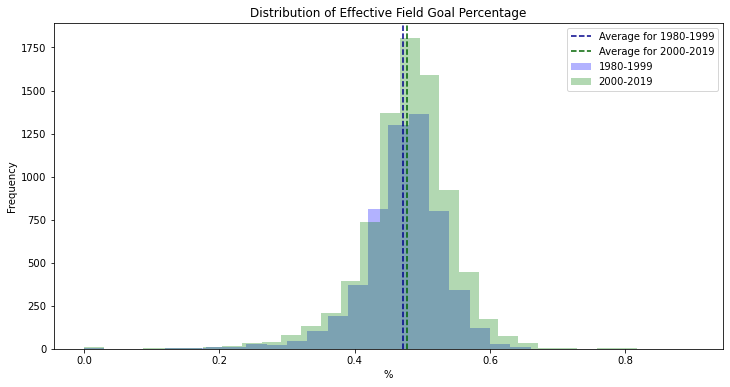

In [369]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(pre_rule['eFG%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['eFG%'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['eFG%'].mean(), color='darkblue', linestyle='dashed', label='Average for 1980-1999')
ax.axvline(post_rule['eFG%'].mean(), color='darkgreen', linestyle='dashed', label='Average for 2000-2019')

ax.set_title('Distribution of Effective Field Goal Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

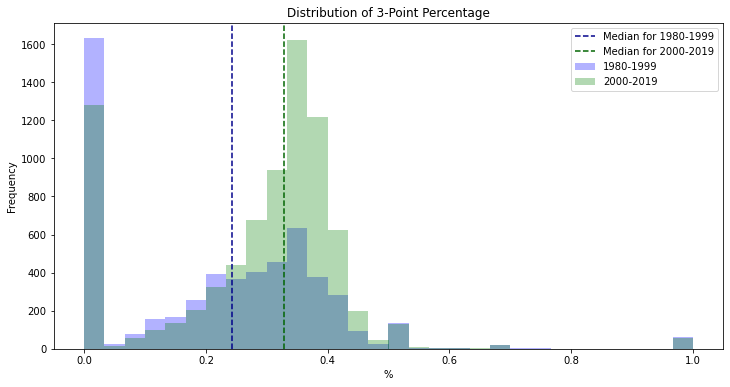

In [370]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(pre_rule['3P%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['3P%'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['3P%'].median(), color='darkblue', linestyle='dashed', label='Median for 1980-1999')
ax.axvline(post_rule['3P%'].median(), color='darkgreen', linestyle='dashed', label='Median for 2000-2019')

ax.set_title('Distribution of 3-Point Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

__The 3-point line was implemented in 1980, so players from the early 1980's were not used to shooting from that far away. Number of 3-point attempts and 3-point percentages increased.__

# Build Model

## PCA

In [371]:
# Drops columns, Year, Player, and Positions, from data and manipulating data into arrays.
# I want to be able to cluster on players based on their performances each season.
X_pre = np.array(pre_rule.drop(['Year', 'Player', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF'], axis=1))
X_post = np.array(post_rule.drop(['Year', 'Player', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF'], axis=1))

In [372]:
X_pre.shape

(5578, 26)

In [373]:
X_post.shape

(8108, 26)

In [374]:
# Scales data.
scaled_pre = StandardScaler().fit_transform(X_pre)
scaled_post = StandardScaler().fit_transform(X_post)

In [375]:
# Initializes and fits PCA's.
pca_pre = PCA().fit(scaled_pre)
pca_post = PCA().fit(scaled_post)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


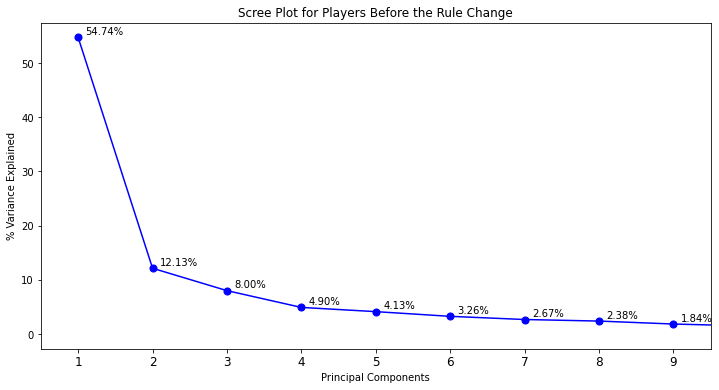

In [467]:
fig, ax = plt.subplots(figsize=(12, 6))

num_components = pca_pre.n_components_
idx = np.arange(num_components)
vals = pca_pre.explained_variance_ratio_*100

ax.plot(idx, vals, color='blue')
ax.scatter(idx, vals, color='blue', s=50)

for i in range(9):
    ax.annotate(r"{:2.2f}%".format(vals[i]), (idx[i]+0.1, vals[i]+0.5))

ax.set_title('Scree Plot for Players Before the Rule Change')
ax.set_xlabel('Principal Components')
ax.set_ylabel('% Variance Explained')

ax.set_xticklabels(idx+1, fontsize=12)
ax.set_xticks(np.arange(9))
ax.set_xlim(left=0-0.5, right=8+0.5);

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


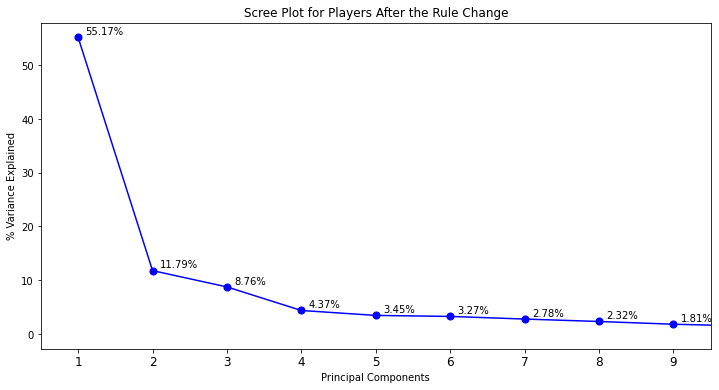

In [466]:
fig, ax = plt.subplots(figsize=(12, 6))

num_components = pca_post.n_components_
idx = np.arange(num_components)
vals = pca_post.explained_variance_ratio_*100

ax.plot(idx, vals, color='blue')
ax.scatter(idx, vals, color='blue', s=50)

for i in range(9):
    ax.annotate(r"{:2.2f}%".format(vals[i]), (idx[i]+0.1, vals[i]+0.5))

ax.set_title('Scree Plot for Players After the Rule Change')
ax.set_xlabel('Principal Components')
ax.set_ylabel('% Variance Explained')

ax.set_xticklabels(idx+1, fontsize=12)
ax.set_xticks(np.arange(9))
ax.set_xlim(left=0-0.5, right=8+0.5);

__Most of the variance in players is explained by the first two principal components before the rule was implemented and after.__

In [386]:
# Creates two PCA models with only two the first two principal components.
pre_2_comp = PCA(n_components=2).fit_transform(scaled_pre)
post_2_comp = PCA(n_components=2).fit_transform(scaled_post)

## KMeans

In [536]:
# Initializes and fits KMeans model using PCA dimension reduced models.
kmeans_pre = KMeans(n_clusters=5, random_state=11).fit(pre_2_comp)
kmeans_post = KMeans(n_clusters=5, random_state=11).fit(post_2_comp)

In [537]:
# Adds cluster assignment column to original dataset.
cluster_labels = kmeans_pre.labels_
pre_rule['Cluster'] = cluster_labels

cluster_labels = kmeans_post.labels_
post_rule['Cluster'] = cluster_labels

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [538]:
# Counts up how many players assigned to each cluster.
cluster_dict_1 = {}
for cluster in pre_rule['Cluster']:
    if cluster not in cluster_dict_1.keys():
        cluster_dict_1[cluster] = 1
    else:
        cluster_dict_1[cluster] += 1

In [539]:
cluster_dict_1

{0: 798, 2: 908, 1: 1738, 3: 1702, 4: 432}

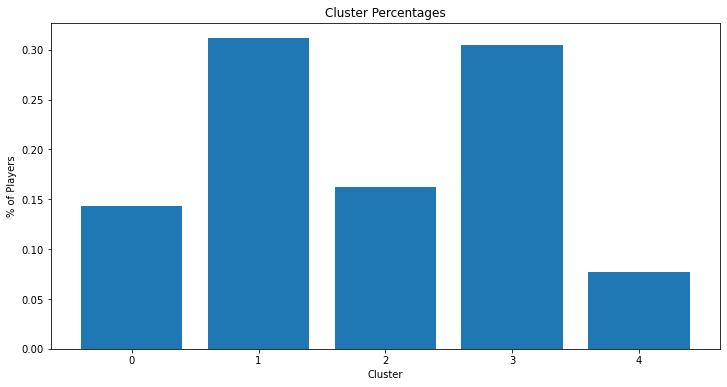

In [540]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(cluster_dict_1.keys(), np.array(list(cluster_dict_1.values()))/len(pre_rule))

ax.set_title('Cluster Percentages')
ax.set_xlabel('Cluster')
ax.set_ylabel('% of Players');

__Now let's do the same thing for the post rule dataset.__

In [541]:
cluster_dict_2 = {}
for cluster in post_rule['Cluster']:
    if cluster not in cluster_dict_2.keys():
        cluster_dict_2[cluster] = 1
    else:
        cluster_dict_2[cluster] += 1

In [542]:
cluster_dict_2

{0: 2281, 2: 832, 3: 3217, 4: 1348, 1: 430}

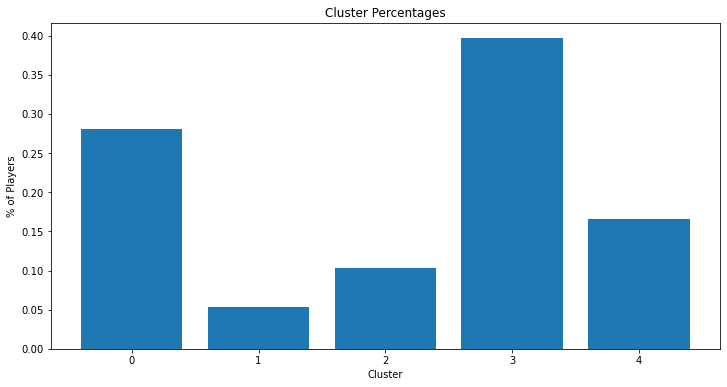

In [543]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(cluster_dict_2.keys(), np.array(list(cluster_dict_2.values()))/len(post_rule))

ax.set_title('Cluster Percentages')
ax.set_xlabel('Cluster')
ax.set_ylabel('% of Players');

In [544]:
# Not really intuitive. Need to find the best number of clusters. Probably not 5.
pre_rule.groupby(['Cluster'])[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']].sum()

,Pos_C,Pos_C-PF,Pos_C-SF,Pos_PF,Pos_PF-C,Pos_PF-SF,Pos_PG,Pos_PG-SF,Pos_PG-SG,Pos_SF,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF
Cluster,,,,,,,,,,,,,,,,
0,4.0,0.0,0.0,11.0,0.0,0.0,353.0,0.0,0.0,137.0,1.0,0.0,290.0,0.0,0.0,2.0
1,192.0,1.0,0.0,306.0,4.0,4.0,405.0,0.0,3.0,347.0,1.0,6.0,461.0,0.0,4.0,4.0
2,257.0,1.0,0.0,333.0,0.0,0.0,23.0,0.0,0.0,203.0,1.0,0.0,90.0,0.0,0.0,0.0
3,237.0,0.0,0.0,309.0,0.0,0.0,401.0,0.0,0.0,387.0,0.0,2.0,365.0,0.0,0.0,1.0
4,107.0,0.0,0.0,137.0,0.0,0.0,25.0,0.0,0.0,108.0,0.0,0.0,55.0,0.0,0.0,0.0


In [520]:
pre = pre_rule.drop(['Year', 'Player', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF'], axis=1)

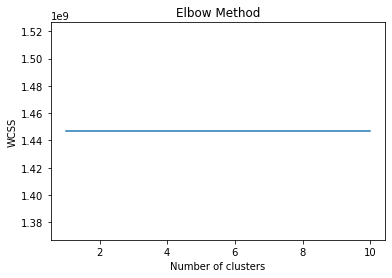

In [521]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans_pre.fit(pre)
    wcss.append(kmeans_pre.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

__KMeans is not a good clustering method.__

## Hierachial Clustering

In [522]:
# use complete or average linkage

In [557]:
# Initializes and fits using the Hiearachial Clustering model.
hier_pre = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(pre_2_comp)
hier_post = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(post_2_comp)

In [558]:
cluster_labels = hier_pre.labels_
pre_rule['Cluster'] = cluster_labels

cluster_labels = hier_post.labels_
post_rule['Cluster'] = cluster_labels

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [559]:
# Counts up how many players assigned to each cluster.
cluster_dict_1 = {}
for cluster in pre_rule['Cluster']:
    if cluster not in cluster_dict_1.keys():
        cluster_dict_1[cluster] = 1
    else:
        cluster_dict_1[cluster] += 1

In [560]:
cluster_dict_1

{1: 2206, 2: 3225, 0: 147}

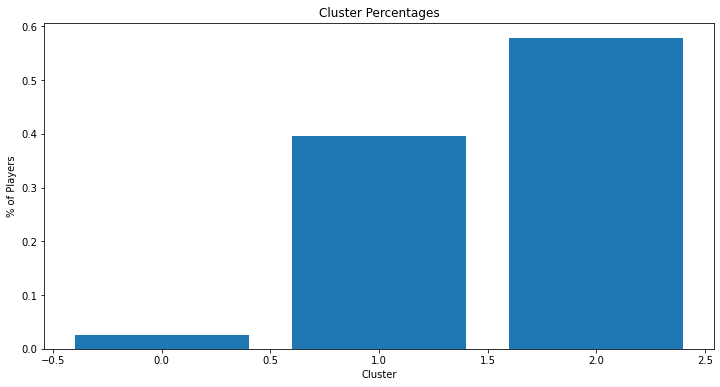

In [561]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(cluster_dict_1.keys(), np.array(list(cluster_dict_1.values()))/len(pre_rule))

ax.set_title('Cluster Percentages')
ax.set_xlabel('Cluster')
ax.set_ylabel('% of Players');

In [562]:
cluster_dict_2 = {}
for cluster in post_rule['Cluster']:
    if cluster not in cluster_dict_2.keys():
        cluster_dict_2[cluster] = 1
    else:
        cluster_dict_2[cluster] += 1

In [563]:
cluster_dict_2

{2: 7451, 0: 650, 1: 7}

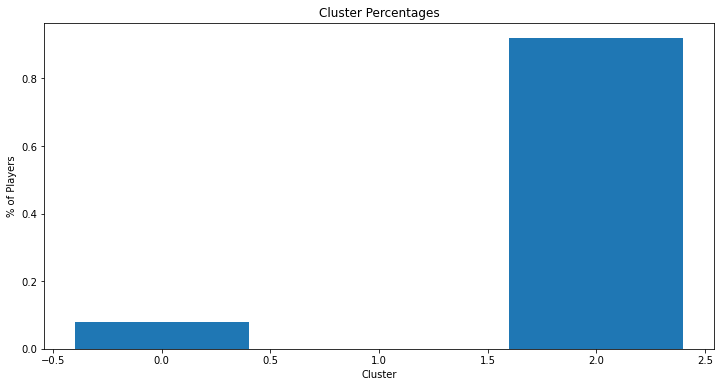

In [564]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(cluster_dict_2.keys(), np.array(list(cluster_dict_2.values()))/len(post_rule))

ax.set_title('Cluster Percentages')
ax.set_xlabel('Cluster')
ax.set_ylabel('% of Players');

In [566]:
pre_rule.groupby(['Cluster'])[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']].sum()

,Pos_C,Pos_C-PF,Pos_C-SF,Pos_PF,Pos_PF-C,Pos_PF-SF,Pos_PG,Pos_PG-SF,Pos_PG-SG,Pos_SF,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF
Cluster,,,,,,,,,,,,,,,,
0,40.0,0.0,0.0,42.0,0.0,0.0,14.0,0.0,0.0,26.0,0.0,0.0,25.0,0.0,0.0,0.0
1,349.0,1.0,0.0,486.0,0.0,0.0,426.0,0.0,0.0,487.0,2.0,0.0,453.0,0.0,0.0,2.0
2,408.0,1.0,0.0,568.0,4.0,4.0,767.0,0.0,3.0,669.0,1.0,8.0,783.0,0.0,4.0,5.0


In [565]:
post_rule.groupby(['Cluster'])[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']].sum()

,Pos_C,Pos_C-PF,Pos_C-SF,Pos_PF,Pos_PF-C,Pos_PF-SF,Pos_PG,Pos_PG-SF,Pos_PG-SG,Pos_SF,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF
Cluster,,,,,,,,,,,,,,,,
0,192.0,0.0,0.0,207.0,0.0,0.0,68.0,0.0,0.0,115.0,0.0,1.0,67.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
2,893.0,16.0,1.0,1338.0,12.0,16.0,1712.0,1.0,25.0,1557.0,15.0,21.0,1804.0,4.0,18.0,18.0
